In [1]:
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(ggalluvial))
suppressMessages(library(ggsci))
options(warn=-1) # use options(warn=0) To turn warnings back on
options(dplyr.summarise.inform = FALSE)
source("../src/confidence_interval.r")

In [2]:
setwd("/Users/inamojun/TMDU-LR_isoform_atlas/Figures")

In [3]:
#load data
load("../data/data_SupFig08.RData")

In [6]:
head(ss)
dim(ss)

id,isoform,position,PARS_score_renatured,PARS_score_rep1,PARS_score_rep2,MFE,scaled_distance_from_cap_TSS2TTS
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_1,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,1,0,0.4501043,0.0000000,-2.200,0.5714286
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_12,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,12,0,0.4501043,0.2640072,-2.800,6.8571429
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_65,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,65,0,0.0000000,-1.7614405,-3.308,37.1428571
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_76,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,76,0,-0.2873317,0.0000000,-3.656,43.4285714
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_102,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,102,0,0.0000000,0.2640072,-5.332,58.2857143
001e7a62-1fc9-4530-93e1-ddd1d73dd5c4_136,001e7a62-1fc9-4530-93e1-ddd1d73dd5c4,136,0,0.2425349,-0.2620688,-1.324,77.7142857


[1] 1867619       8

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



pdf 
  2

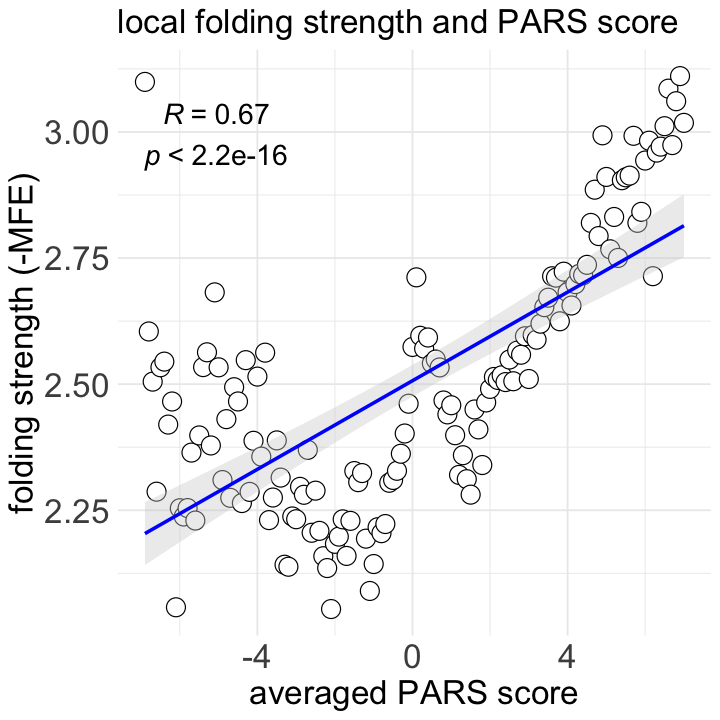

In [5]:
options(repr.plot.width=6, repr.plot.height=6)
g = ss %>%
  # dplyr::filter((PARS_score_renatured+PARS_score_rep1+PARS_score_rep2)/3 < as.numeric(quantile((merged$PARS_score_renatured+merged$PARS_score_rep1+merged$PARS_score_rep2)/3, probs = seq(0, 1, 0.01))["99%"]) &
  #                (PARS_score_renatured+PARS_score_rep1+PARS_score_rep2)/3 > as.numeric(quantile((merged$PARS_score_renatured+merged$PARS_score_rep1+merged$PARS_score_rep2)/3, probs = seq(0, 1, 0.01))["1%"])) %>%
  dplyr::mutate(PARS_score_bin = cut((PARS_score_renatured+PARS_score_rep1+PARS_score_rep2)/3, breaks=c(seq(-7,7,0.1))) %>% stringr::str_split(.,pattern=",",simplify = TRUE) %>% .[,2] %>% gsub("\\]","",.) %>% as.numeric(),
                folding_strength = -1*MFE,
                region = case_when(
                  scaled_distance_from_cap_TSS2TTS <=100 ~ "5'UTR",
                  scaled_distance_from_cap_TSS2TTS <=200 & scaled_distance_from_cap_TSS2TTS > 100 ~ "CDS",
                  scaled_distance_from_cap_TSS2TTS <=300 & scaled_distance_from_cap_TSS2TTS > 200 ~ "3'UTR"
                ),
                region = factor(region, levels=c("5'UTR","CDS","3'UTR"))) %>%
  dplyr::group_by(PARS_score_bin) %>%
  dplyr::summarize(folding_strength_mean = mean(folding_strength),
                   folding_strength_CI_up = confidence_interval_upper(folding_strength),
                   folding_strength_CI_low = confidence_interval_lower(folding_strength)
  ) %>%
  as.data.frame() %>%
  na.omit() %>%
  ggscatter(., x = "PARS_score_bin", y = "folding_strength_mean",
            color = "black", shape = 21, size = 5, # Points color, shape and size
            add = "reg.line",  # Add regressin line
            add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
            conf.int = TRUE, # Add confidence interval
            cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
            cor.coeff.args = list(method = "spearman", label.sep = "\n"), cor.coef.size = 6
  ) +
  ggtitle("local folding strength and PARS score") +
  ylab(paste0("folding strength (-MFE)")) +
  # xlab("averaged PARS score\n[PARS_score_renatured+PARS_score_rep1+PARS_score_rep2]") +
  xlab("averaged PARS score") +
  theme_minimal() +
  theme(strip.text.x=element_text(size=20, color="black", face="bold"),
        strip.text.y=element_text(size=20, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size =20),
        axis.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        legend.text =  element_text(size = 20), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0))
g
pdf("./FigS8.pdf", width=6, height=6)
g
dev.off()